# This notebook is for the FairSHAP experiment

In [1]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [3]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
os.chdir(project_root)

### 2. Import dataset

In [4]:
from src.dataloader.unified_dataloader import load_dataset

a, processed_compas4race= load_dataset('compas4race')

In [5]:
processed_compas4race.head(3)

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_F,c_charge_degree_M,type_of_assessment_Risk of Recidivism,score_text_High,score_text_Low,score_text_Medium,two_year_recid
0,1,-0.061334,1,-0.162011,-0.195526,-0.227625,-0.735792,1,0,1,0,1,0,1
1,1,-0.901239,1,-0.162011,-0.195526,1.703263,0.059694,1,0,1,0,1,0,1
2,1,-0.985229,1,-0.162011,1.785502,-0.227625,-0.536921,1,0,1,1,0,0,0


### 3. Split label/unlabel data, split train/test data.

In [6]:
'''COMPAS for race research'''
df = processed_compas4race.copy()
X = df.drop('two_year_recid', axis=1)
y = df['two_year_recid']

In [7]:
from experiments.five_fold_cross_validation import cross_validate
model = XGBClassifier()
cross_validate(model=model, X=X, y=y, num_folds=5, dataset_name='compas4race',matching_method='NN')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


-------------------------------------
-------------1th fold----------------
-------------------------------------
1. Split the compas4race dataset into majority group and minority group according to the number of sensitive attribute, besides split by label 0 and label 1
X_train_majority_label0 shape: (1427, 13)
X_train_majority_label1 shape: (1514, 13)
X_train_minority_label0 shape: (1199, 13)
X_train_minority_label1 shape: (780, 13)
2. Initialize FairnessExplainer
--------Next, we will modify the minority group--------
3(a). Match X_train_minority_label0 with X_train_majority_label0
3(b). Match X_train_minority_label1 with X_train_majority_label1
4(a). Use FairSHAP to find suitable values from X_train_majority_label0 to replace data in X_train_minority_label0
4(b). Use FairSHAP to find suitable values from X_train_majority_label1 to replace data in X_train_minority_label1
5. Calculate varphi and q
There are 299 SHAP values greater than 0.05 in X_train_minority
--------Next, we will mo

### 4. read saved_csv file and make plots. FairSHAP(DR), threshold=0.05

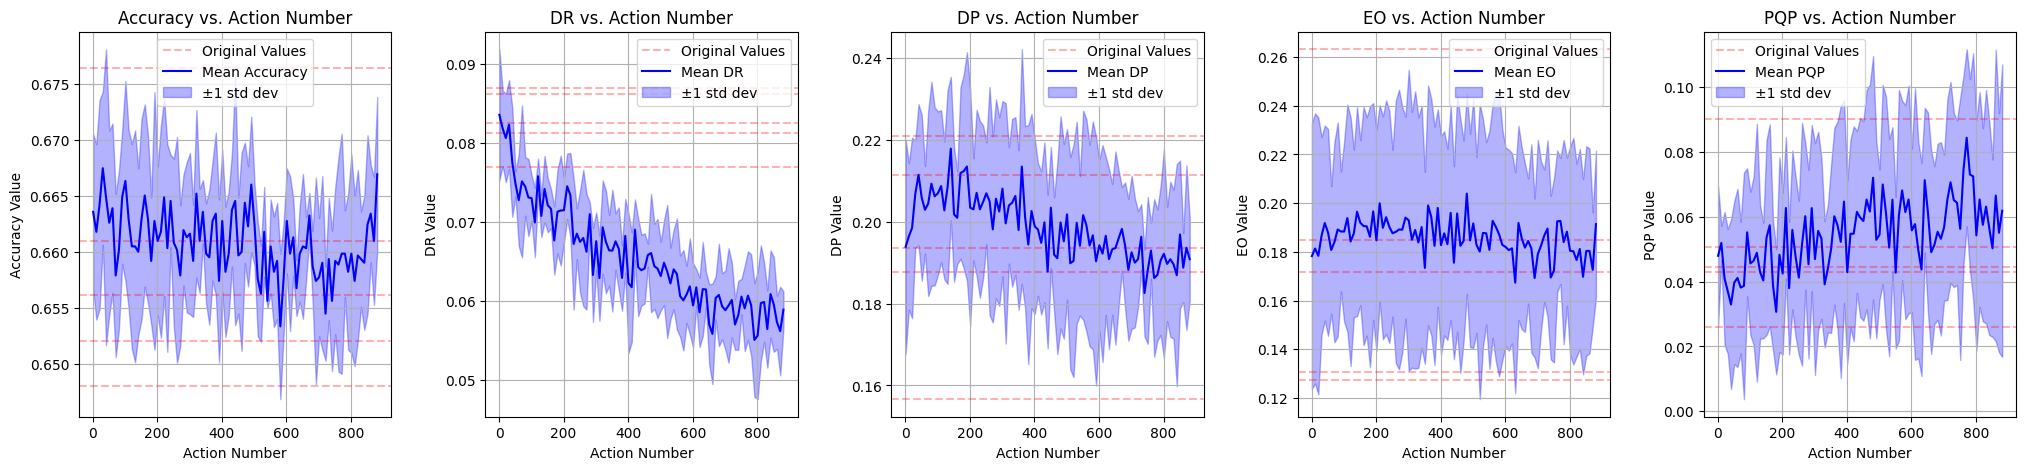

In [8]:
import pandas as pd
import numpy as np
from src.visualization.viz_absolute_metrics import plot_results

def extract_original_values(fold):
    original_accuracy = fold.loc[0, 'new_accuracy']
    original_DR = fold.loc[0, 'new_DR']
    original_DP = fold.loc[0, 'new_DP']
    original_EO = fold.loc[0, 'new_EO']
    original_PQP = fold.loc[0, 'new_PQP']
    return original_accuracy, original_DR, original_DP, original_EO, original_PQP

fold1 = pd.read_csv('saved_results/compas4race/2-4_fairSHAP-KernelExplainer-0.05_NN_1-fold_results.csv')
fold2 = pd.read_csv('saved_results/compas4race/2-4_fairSHAP-KernelExplainer-0.05_NN_2-fold_results.csv')
fold3 = pd.read_csv('saved_results/compas4race/2-4_fairSHAP-KernelExplainer-0.05_NN_3-fold_results.csv')
fold4 = pd.read_csv('saved_results/compas4race/2-4_fairSHAP-KernelExplainer-0.05_NN_4-fold_results.csv')
fold5 = pd.read_csv('saved_results/compas4race/2-4_fairSHAP-KernelExplainer-0.05_NN_5-fold_results.csv')

fold1_original_values = extract_original_values(fold1)
fold2_original_values = extract_original_values(fold2)
fold3_original_values = extract_original_values(fold3)
fold4_original_values = extract_original_values(fold4)
fold5_original_values = extract_original_values(fold5)

fold1.drop(fold1.index[0], inplace=True)
fold2.drop(fold2.index[0], inplace=True)
fold3.drop(fold3.index[0], inplace=True)
fold4.drop(fold4.index[0], inplace=True)
fold5.drop(fold5.index[0], inplace=True)

folds = [fold1, fold2, fold3, fold4, fold5]
original_accuracy = [fold1_original_values[0], fold2_original_values[0], fold3_original_values[0], fold4_original_values[0], fold5_original_values[0]]
original_drs = [fold1_original_values[1], fold2_original_values[1], fold3_original_values[1], fold4_original_values[1], fold5_original_values[1]]
original_dps = [fold1_original_values[2], fold2_original_values[2], fold3_original_values[2], fold4_original_values[2], fold5_original_values[2]]
original_eos = [fold1_original_values[3], fold2_original_values[3], fold3_original_values[3], fold4_original_values[3], fold5_original_values[3]]
original_pqps = [fold1_original_values[4], fold2_original_values[4], fold3_original_values[4], fold4_original_values[4], fold5_original_values[4]]

# 调用函数
plot_results(
    folds=folds,
    original_accuracy=original_accuracy,
    original_DR=original_drs, 
    original_DP=original_dps, 
    original_EO=original_eos, 
    original_PQP=original_pqps,
    stop_when_no_data=3,
    min_action=1,
    figsize=None,
    fill_alpha=0.3,
    fill_color='b',
    red_alpha=0.3
)

In [9]:
fold_last_rows = [
    fold1.iloc[-1], 
    fold2.iloc[-1], 
    fold3.iloc[-1], 
    fold4.iloc[-1], 
    fold5.iloc[-1]
]

# Convert to DataFrame for calculating mean and std
df_last_rows = pd.DataFrame(fold_last_rows)

# Calculate mean and std for each column
mean_values = df_last_rows.mean()
std_values = df_last_rows.std()

# Combine into a new DataFrame showing "mean ± std" format
result_df = pd.DataFrame({
    "Mean": mean_values,
    "Std": std_values,
    "Mean ± Std": mean_values.round(4).astype(str) + " ± " + std_values.round(4).astype(str)
})
result_df

,Mean,Std,Mean ± Std
action_number,905.000000,59.413803,905.0 ± 59.4138
new_accuracy,0.661463,0.008183,0.6615 ± 0.0082
new_DR,0.058465,0.004452,0.0585 ± 0.0045
new_DP,0.190656,0.008408,0.1907 ± 0.0084
new_EO,0.176740,0.030352,0.1767 ± 0.0304
new_PQP,0.056954,0.041425,0.057 ± 0.0414


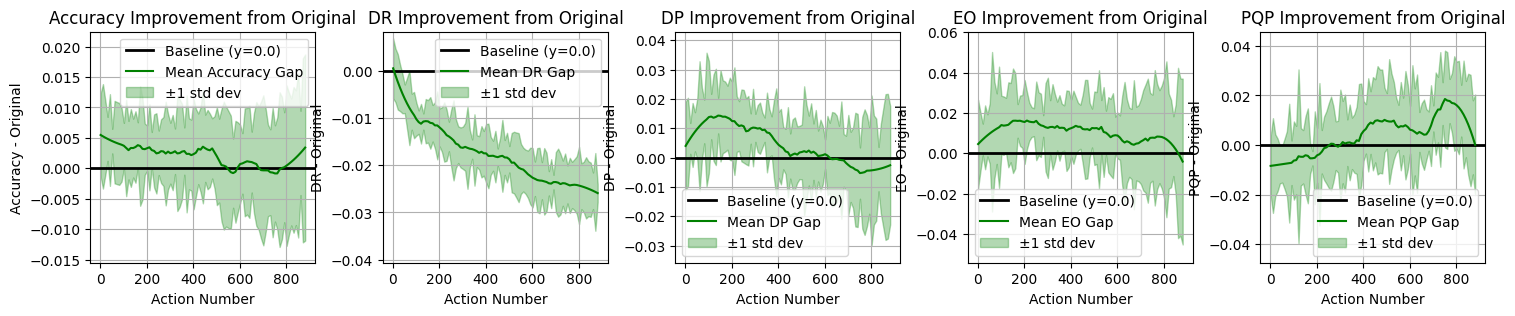

In [10]:
from src.visualization.viz_improvement_metrics import plot_fairness_improvement

plot_fairness_improvement(
    folds=folds,
    original_accuracy=original_accuracy,
    original_DR=original_drs,
    original_DP=original_dps,
    original_EO=original_eos,
    original_PQP=original_pqps,
    stop_when_no_data=3,  
    min_action=1,
    baseline=0.0,
    figsize=(18,3),
    fill_alpha=0.3,
    fill_color='g',
    smooth_window=20,
    smooth_polyorder=2,
)